# M2 预测能力

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# 统一图表样式
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 7)

In [5]:
data = pd.read_csv("m2_growth.csv", index_col="DateTime", parse_dates=True)
data.index.name = "datetime"
data.columns = ["btc_price", "m2_yoy", "m2_usd"]
data

,btc_price,m2_yoy,m2_usd
datetime,,,
2013-05-20,117.818636,5.565401,59166686473105
2013-05-27,126.392906,5.857141,59490171457382
2013-06-03,122.949188,6.767055,60072386054198
2013-06-10,104.357567,7.297086,60559839608422
2013-06-17,100.126305,6.508455,59754983891203
...,...,...,...
2025-06-09,110198.158714,8.153580,112305459146722
2025-06-16,107243.933346,8.306785,112280636517733
2025-06-23,105496.947495,8.211908,112798011931028


## 探索性数据分析

计算比特币的年收益率。

In [6]:
# 删除不需要的列
data.drop(columns="m2_usd", inplace=True)

# 计算比特币价格的同比增长率 (BTC YoY Growth)
data["btc_yoy"] = (data["btc_price"] / data["btc_price"].shift(52) - 1) * 100

# 处理因计算而产生的缺失值
data_prepared = data.dropna().copy()

data_prepared

,btc_price,m2_yoy,btc_yoy
datetime,,,
2014-05-19,447.404857,7.822699,279.740311
2014-05-26,584.847975,7.735780,362.722153
2014-06-02,663.505724,6.618120,439.658484
2014-06-09,648.336322,5.935706,521.264316
2014-06-16,590.567482,7.367577,489.822506
...,...,...,...
2025-06-09,110198.158714,8.153580,58.636253
2025-06-16,107243.933346,8.306785,61.308178
2025-06-23,105496.947495,8.211908,75.072646


绘制时间序列图表，对比 m2 同比增速和比特币年收益率的关系。

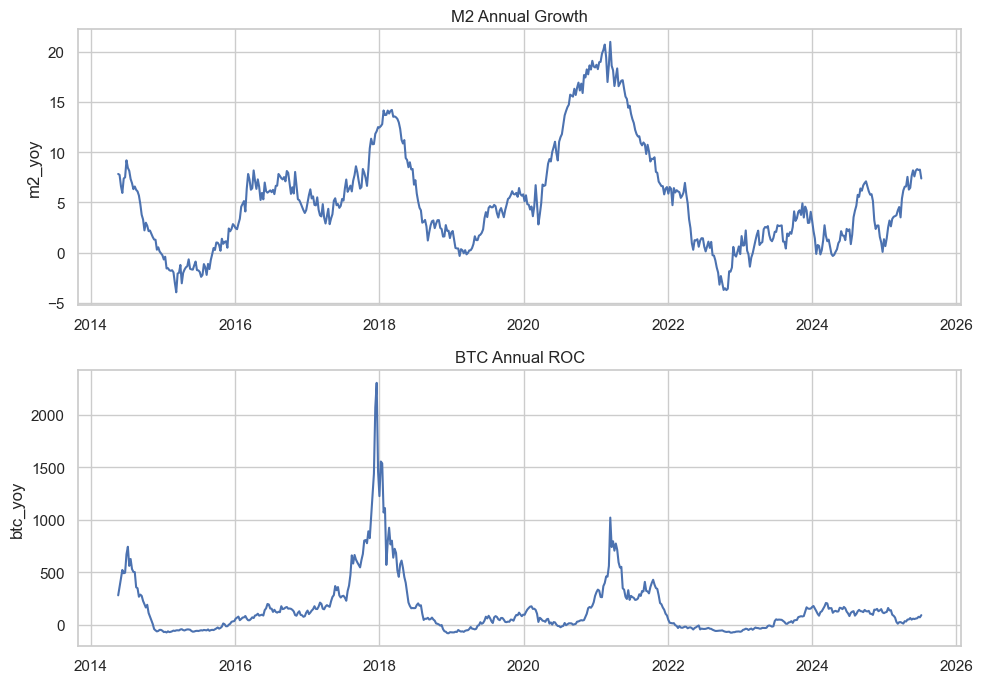

In [7]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1)

sns.lineplot(data_prepared, x=data_prepared.index, y="m2_yoy", ax=ax0)
sns.lineplot(data_prepared, x=data_prepared.index, y="btc_yoy", ax=ax1)

ax0.set_title("M2 Annual Growth")
ax0.set_xlabel("")
ax1.set_title("BTC Annual ROC")
ax1.set_xlabel("")

plt.tight_layout()

检验 m2 同比增长率和比特币年收益率是否平稳。

In [8]:
def perform_adf_test(timeseries: pd.Series, significance_level: float = 0.05):
    """
    使用增广迪基-福勒检验 (ADF Test) 检验时间序列的平稳性。

    参数:
    timeseries : pd.Series, 需要进行检验的时间序列数据。
    significance_level : float, optional, 显著性水平，用于判断是否拒绝原假设。

    返回: None, 函数会直接打印出检验结果和结论。
    """
    print("=" * 40)
    print("Augmented Dickey-Fuller Test Results   ")
    print("=" * 40)

    # 执行ADF检验
    # autolag='AIC' 表示让模型自动选择最优的滞后阶数
    adf_result = adfuller(timeseries, autolag="AIC")

    # 提取并格式化输出结果
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    lags_used = adf_result[2]
    n_observations = adf_result[3]
    critical_values = adf_result[4]

    print(f"ADF Statistic          : {adf_statistic:.4f}")
    print(f"p-value                : {p_value:.4f}")
    print(f"Lags Used              : {lags_used}")
    print(f"Number of Observations : {n_observations}")

    print("\nCritical Values:")
    for key, value in critical_values.items():
        print(f"   {key:<5}: {value:.4f}")

    print("-" * 40)

    # 根据p-value得出结论
    print("Conclusion:")
    if p_value <= significance_level:
        print(f"p-value ({p_value:.4f}) is less than or equal to {significance_level}.")
        print(
            ">> Reject the null hypothesis (H0). The time series is likely STATIONARY."
        )
    else:
        print(f"p-value ({p_value:.4f}) is greater than {significance_level}.")
        print(
            ">> Fail to reject the null hypothesis (H0). The time series is likely NON-STATIONARY."
        )
    print("=" * 40)

In [9]:
perform_adf_test(data_prepared["m2_yoy"])

Augmented Dickey-Fuller Test Results   
ADF Statistic          : -2.3987
p-value                : 0.1421
Lags Used              : 6
Number of Observations : 572

Critical Values:
   1%   : -3.4418
   5%   : -2.8666
   10%  : -2.5695
----------------------------------------
Conclusion:
p-value (0.1421) is greater than 0.05.
>> Fail to reject the null hypothesis (H0). The time series is likely NON-STATIONARY.


In [10]:
perform_adf_test(data_prepared["btc_yoy"])

Augmented Dickey-Fuller Test Results   
ADF Statistic          : -3.5089
p-value                : 0.0078
Lags Used              : 7
Number of Observations : 571

Critical Values:
   1%   : -3.4419
   5%   : -2.8666
   10%  : -2.5695
----------------------------------------
Conclusion:
p-value (0.0078) is less than or equal to 0.05.
>> Reject the null hypothesis (H0). The time series is likely STATIONARY.


进一步数据转换：

- 计算 m2 同比增速的一阶差分
- 计算年收益率的对数

In [11]:
# 计算 m2 同比增速的一阶差分
data_prepared["diff_m2_yoy"] = data_prepared["m2_yoy"].diff()

# 计算比特币年收益率的对数转换
data_prepared["log_btc_yoy"] = np.log1p(data_prepared["btc_yoy"] / 100)

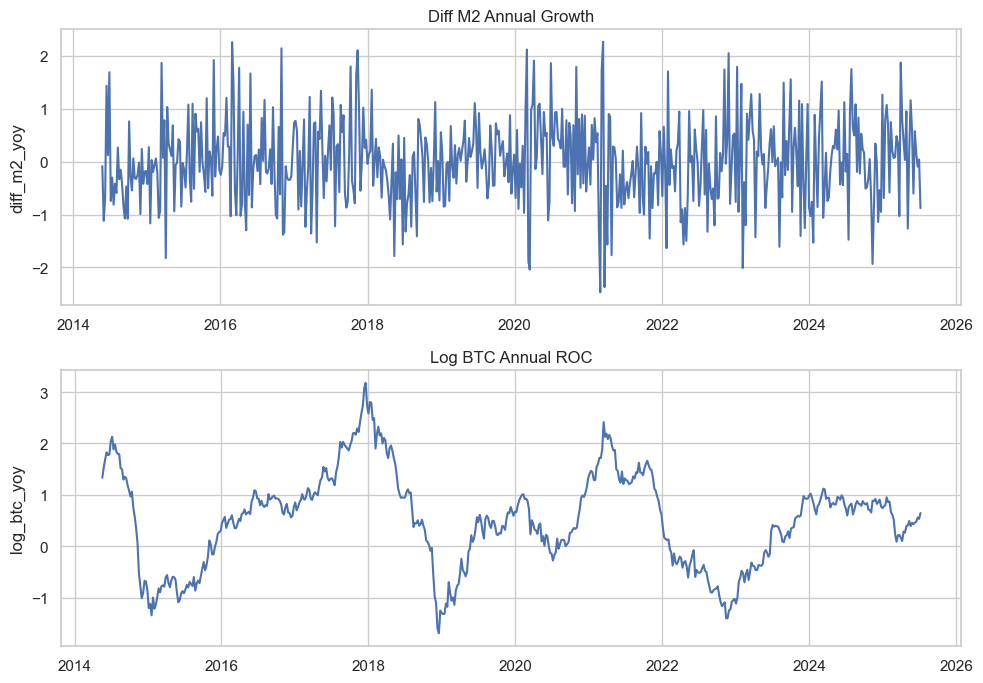

In [12]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1)

sns.lineplot(data_prepared, x=data_prepared.index, y="diff_m2_yoy", ax=ax0)
sns.lineplot(data_prepared, x=data_prepared.index, y="log_btc_yoy", ax=ax1)

ax0.set_xlabel("")
ax0.set_title("Diff M2 Annual Growth")
ax1.set_xlabel("")
ax1.set_title("Log BTC Annual ROC")

plt.tight_layout()

再次进行 adf 检验。

In [14]:
perform_adf_test(data_prepared["diff_m2_yoy"].dropna())

Augmented Dickey-Fuller Test Results   
ADF Statistic          : -7.4986
p-value                : 0.0000
Lags Used              : 5
Number of Observations : 572

Critical Values:
   1%   : -3.4418
   5%   : -2.8666
   10%  : -2.5695
----------------------------------------
Conclusion:
p-value (0.0000) is less than or equal to 0.05.
>> Reject the null hypothesis (H0). The time series is likely STATIONARY.


In [15]:
perform_adf_test(data_prepared["log_btc_yoy"].dropna())

Augmented Dickey-Fuller Test Results   
ADF Statistic          : -3.2946
p-value                : 0.0151
Lags Used              : 9
Number of Observations : 569

Critical Values:
   1%   : -3.4419
   5%   : -2.8666
   10%  : -2.5695
----------------------------------------
Conclusion:
p-value (0.0151) is less than or equal to 0.05.
>> Reject the null hypothesis (H0). The time series is likely STATIONARY.


In [23]:
# 创建领先的M2同比增长率变量 (Lagged M2 YoY)
lags_to_create = [4, 8, 10, 12, 26, 52]  # 定义要创建的领先周数
for lag in lags_to_create:
    data_prepared[f"diff_m2_yoy_lag_{lag}w"] = data_prepared["diff_m2_yoy"].shift(lag)

# 删除缺失值
data_prepared = data_prepared.dropna().copy()

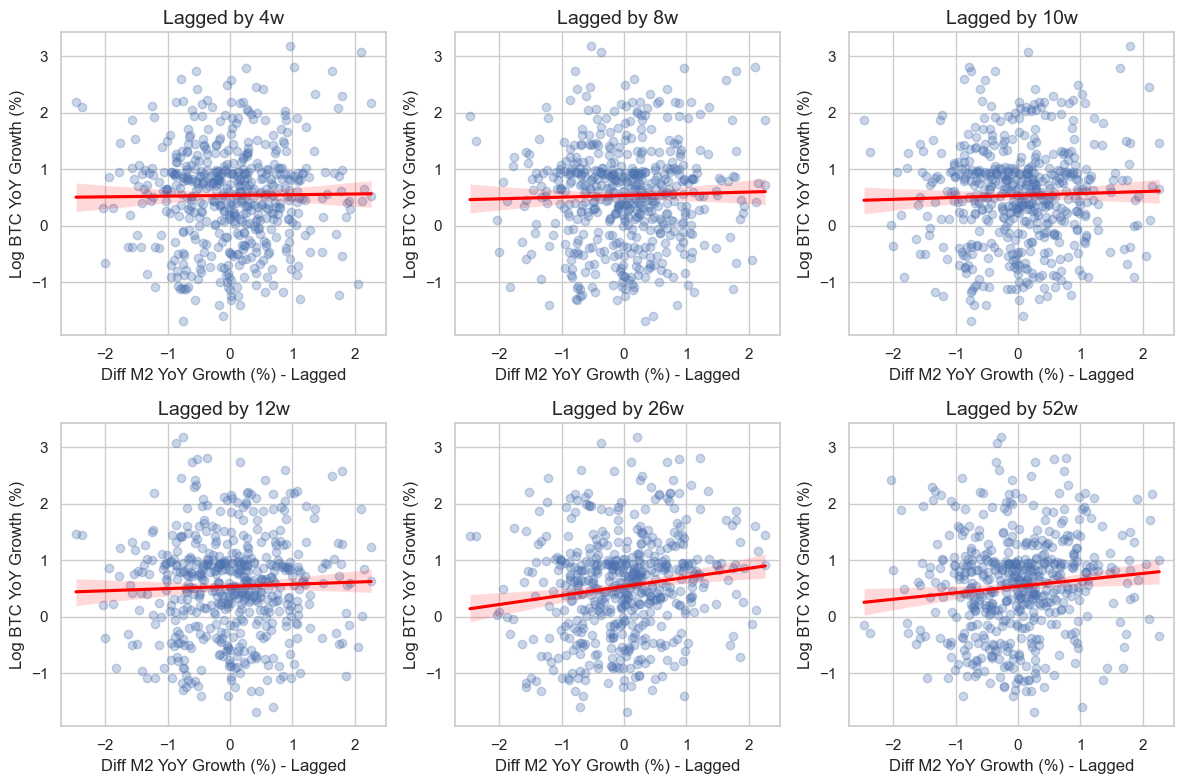

In [30]:
# 创建散点图，探索领先的M2增速的变化与对数比特币年收益率的关系

# 定义我们在第一阶段创建的领先变量列名
lag_cols = [f"diff_m2_yoy_lag_{lag}w" for lag in lags_to_create]

# 创建一个 2x3 的子图网格
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, lag_col in enumerate(lag_cols):
    sns.regplot(
        data=data_prepared,
        x=lag_col,
        y="log_btc_yoy",
        ax=axes[i],
        scatter_kws={"alpha": 0.3},  # 让点半透明，以观察重叠情况
        line_kws={"color": "red"},
    )  # 让拟合线为红色
    axes[i].set_title(f'Lagged by {lag_col.split("_")[-1]}', fontsize=14)
    axes[i].set_xlabel(f"Diff M2 YoY Growth (%) - Lagged")
    axes[i].set_ylabel("Log BTC YoY Growth (%)")

# 优化布局，防止标题重叠
plt.tight_layout()

## 3. 回归模型

$$log(1 + btc\_yoy/100) = \beta_0 + \beta_1 * m2\_yoy\_lag\_13w$$

如何解读斜率系数？

自变量X每增加一个单位，因变量Y大约会发生$(100*\beta_1)\%$的百分比变化。

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf  # 使用公式API，更直观

# --- 步骤 1: 定义并拟合回归模型 ---

# 我们使用 statsmodels 的公式API，语法非常类似R语言，清晰易读
# 公式 'y ~ x' 表示我们想要用 x 来预测 y
# 'log_btc_yoy' 是我们的因变量 (y)
# 'm2_yoy_lag_13w' 是我们的自变量 (x)
formula = "log_btc_yoy ~ diff_m2_yoy_lag_26w"

# 使用 OLS (Ordinary Least Squares) 普通最小二乘法建立模型
# smf.ols 会根据公式和数据自动处理截距项
model = smf.ols(formula=formula, data=data_prepared)

# .fit() 方法执行实际的回归计算
results = model.fit()

# --- 步骤 2: 显示并解读模型结果 ---

print("========= OLS Regression Results =========")
print(results.summary())
print("==========================================")

# # --- 步骤 3: 提取关键系数并进行预测演示 ---

# # 从结果中提取截距 (β₀) 和斜率 (β₁)
# beta_0 = results.params["Intercept"]
# beta_1 = results.params["m2_yoy_lag_13w"]

# print("\n--- 模型系数解读 ---\n")
# print(f"回归方程为: log_btc_yoy = {beta_0:.4f} + {beta_1:.4f} * m2_yoy_lag_13w")
# print(f"斜率系数 (β₁) 为 {beta_1:.4f}。")
# print(
#     f"领先13周的M2同比增速每增加1个百分点, 比特币的对数同比增长率预计增加 {beta_1:.4f}。"
# )
# print(f"换算成百分比效应，比特币的同比增长率预计会增长约 {beta_1*100:.2f}%。")

# # 演示如何用模型进行预测
# # 假设我们想预测当领先13周的M2增速为 5% 时的情况
# m2_scenario = 5

# # 1. 计算预测的对数值
# predicted_log_value = beta_0 + beta_1 * m2_scenario

# # 2. 将对数值转换回实际的百分比增长率
# predicted_btc_yoy = (np.exp(predicted_log_value) - 1) * 100

# print("\n--- 预测示例 ---")
# print(f"当领先13周的M2增速为 {m2_scenario}% 时:")
# print(f"  1. 模型预测的对数同比增长率为: {predicted_log_value:.4f}")
# print(
#     f"  2. 将其转换回实际百分比，预测的比特币年同比增长率为: {predicted_btc_yoy:.2f}%"
# )

========= OLS Regression Results =========
                            OLS Regression Results                            
Dep. Variable:            log_btc_yoy   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     11.45
Date:                Thu, 17 Jul 2025   Prob (F-statistic):           0.000770
Time:                        17:06:34   Log-Likelihood:                -671.89
No. Observations:                 526   AIC:                             1348.
Df Residuals:                     524   BIC:                             1356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [33]:
data_prepared

,btc_price,m2_yoy,btc_yoy,diff_m2_yoy,log_btc_yoy,diff_m2_yoy_lag_4w,diff_m2_yoy_lag_8w,diff_m2_yoy_lag_10w,diff_m2_yoy_lag_12w,diff_m2_yoy_lag_26w,diff_m2_yoy_lag_52w
datetime,,,,,,,,,,,
2015-05-25,237.003543,-1.670289,-59.476043,-0.059497,-0.903277,0.223335,0.779709,1.863553,-1.062706,-0.021065,-0.086918
2015-06-01,223.282702,-1.692481,-66.348037,-0.022192,-1.089099,0.108502,-1.823036,0.073839,-0.925004,-0.990656,-1.117661
2015-06-08,228.774291,-1.269127,-64.713640,0.423354,-1.041674,0.685847,1.031106,0.779709,1.863553,0.238999,-0.682414
2015-06-15,236.790963,-0.890798,-59.904504,0.378329,-0.913906,-0.941104,0.335959,-1.823036,0.073839,-0.420876,1.431871
2015-06-22,247.017892,-1.742048,-58.100767,-0.851250,-0.869903,-0.059497,0.223335,1.031106,0.779709,-0.187882,0.121326
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,110198.158714,8.153580,58.636253,0.573796,0.461444,0.176780,0.372494,1.869116,0.341600,-1.139571,-0.015018
2025-06-16,107243.933346,8.306785,61.308178,0.153205,0.478147,1.158285,0.031037,0.807027,-1.029487,-0.540466,-0.445944
2025-06-23,105496.947495,8.211908,75.072646,-0.094877,0.560031,0.579623,0.950090,0.372494,1.869116,-0.949540,1.121561


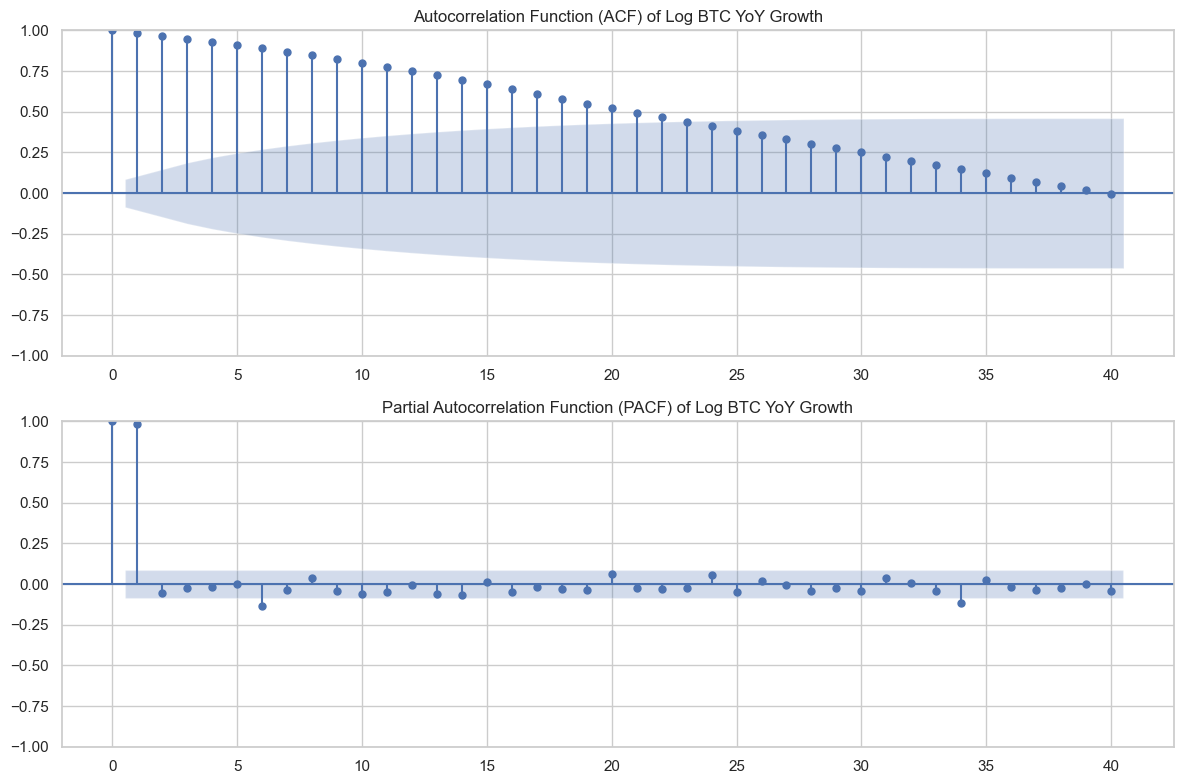


根据ACF/PACF图的典型形态, 我们初步选择AR(2)模型, 即 order=(2, 0, 0)。
您需要根据您生成的实际图形来确认或调整这个选择。



In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# --- 步骤 1: 确定ARIMA阶数 (p, d, q) ---

# d=0: 我们的因变量 log_btc_yoy 已经是平稳的，所以不需要差分。
# 我们需要通过ACF和PACF图来确定p(AR阶数)和q(MA阶数)。

# 创建一个2x1的子图网格
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 绘制ACF图
plot_acf(data_prepared["log_btc_yoy"].dropna(), ax=axes[0], lags=40)
axes[0].set_title("Autocorrelation Function (ACF) of Log BTC YoY Growth")

# 绘制PACF图
plot_pacf(data_prepared["log_btc_yoy"].dropna(), ax=axes[1], lags=40)
axes[1].set_title("Partial Autocorrelation Function (PACF) of Log BTC YoY Growth")

plt.tight_layout()
plt.show()

# --- ACF/PACF图解读 (这是一个示例，您需要根据实际图形调整) ---
# 观察:
# - ACF图表现出缓慢衰减（拖尾），这是典型的AR过程特征。
# - PACF图可能在第1或第2个滞后阶后突然截断（变为不显著）。
# 结论:
# - 这强烈暗示了一个AR(p)模型。如果PACF在p阶后截尾，我们就选择p作为AR阶数。
# - 假设我们观察到PACF在第2阶后截尾，我们将选择p=2, q=0。
# - 我们的模型阶数将是 order=(2, 0, 0)。这是一个AR(2)模型。
# 注意：阶数选择有时需要一些尝试和比较（例如比较不同阶数模型的AIC值）。我们先从一个合理的p,q开始。

print("\n根据ACF/PACF图的典型形态, 我们初步选择AR(2)模型, 即 order=(2, 0, 0)。")
print("您需要根据您生成的实际图形来确认或调整这个选择。\n")

In [44]:
# --- 步骤 2: 准备数据 ---

# 定义因变量 (endog) 和外生变量 (exog)
# 基于您之前的发现，我们选择领先26周的差分M2增速作为外生变量
endog_var = "log_btc_yoy"
exog_var = "diff_m2_yoy_lag_26w"

# 为了确保没有缺失值导致模型出错，我们再次清理数据
# 这会同时移除因变量和外生变量中的任何NaN值
model_data = data_prepared[[endog_var, exog_var]].dropna().copy()

y = model_data[endog_var]
X = model_data[[exog_var]]  # 保持为DataFrame格式

# --- 步骤 3: 建立并拟合ARIMAX模型 ---

# 定义模型
# endog=y: 因变量
# exog=X: 外生变量
# order=(2, 0, 0): 我们根据ACF/PACF图初步选择的(p,d,q)阶数
# freq='W': 明确告知模型数据是周度频率，有助于处理日期
arimax_model = ARIMA(endog=y, exog=X, order=(2, 0, 0))

# 拟合模型
# 注意：ARIMA模型拟合可能比OLS需要更长的时间
results_arimax = arimax_model.fit()


# --- 步骤 4: 展示并解读结果 ---
print(results_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:            log_btc_yoy   No. Observations:                  526
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 278.221
Date:                Thu, 17 Jul 2025   AIC                           -546.443
Time:                        17:37:39   BIC                           -525.116
Sample:                             0   HQIC                          -538.092
                                - 526                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3963      0.376      1.055      0.292      -0.340       1.133
diff_m2_yoy_lag_26w     0.0024      0.006      0.424      0.672      -0.009       0.013
ar.L1           

/Users/scofield/quant-research/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/scofield/quant-research/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/scofield/quant-research/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
